In [8]:
import random
import numpy as np
from statistics import mean
from random import randrange
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
import sys
from scipy.spatial import distance
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import LeaveOneOut
%matplotlib inline

## Data Pre-processing

load both train and test data

In [11]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')

In [12]:
X_train, y_train, X_test, y_test = train_small[:,1:], train_small[:,0], test_small[:,1:], test_small[:,0]

data pre-processing by normalizing data

In [13]:
def min_max_scaler(data):
    return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))

In [14]:
X_train_normed = min_max_scaler(X_train)
X_test_normed = min_max_scaler(X_test)

<ipython-input-13-76f6facb0633>:2: RuntimeWarning: invalid value encountered in true_divide
  return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))


## K-Nearest Neighbor

In [20]:
class KNearestNeighbors():
    """ K-nearest neighbour aka KNN classifier
    
    Parameters
    -------------
    k : int classes
    p : int parameter p in Minkowski Distance calculation
    
    Attributes
    -------------
    
    """
    
    # initialize parameters in KNN model
    def __init__(self, k, p=2):
        self.k = k
        self.p = p    
    
    def compute_distance(self, X_test):
#         distances = np.sqrt(np.sum(X_test**2, axis=1, keepdims=True) + np.sum(self.X_train**2, axis=1, keepdims=True).T - 2*np.dot(X_test, self.X_train.T))
        distances=distance.cdist(X_test,self.X_train,'minkowski', p=self.p)
        return distances
    
#     def compute_distance(self, X_test):
#         num_test = X_test.shape[0]
#         num_train = self.X_train.shape[0]
#         distances = np.zeros((num_test, num_train))

#         for i in range(num_test):
#             for j in range(num_train):
#                 distances[i, j] = np.sum(np.absolute(X_test[i,:] - self.X_train[j,:])**self.p)**(self.p**-1)
#         return distances
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X_test):
        
        #compute distances between 
        distances = self.compute_distance(X_test)
        
        #generate predictions
        n_test = distances.shape[0]
        y_pred = np.zeros(n_test)
        for i in range(n_test):
            y_index = np.argsort(distances[i, :])
            k_closests = self.y_train[y_index[:self.k]].astype(int)
            y_pred[i] = np.argmax(np.bincount(k_closests))
        return y_pred
    

## Sanity Check

In [22]:
KNN = KNearestNeighbors(5,2)
KNN.fit(X_train,y_train)
start_time = time.time()
y_pred = KNN.predict(X_test)
print(time.time()-start_time)
print("Accuracy:", np.sum(y_pred == y_test)/y_test.shape[0])

41.83453869819641
Accuracy: 0.917


## Cross Validation with scikit-learn to determine K and P

In [23]:
start_time = time.time()
neigh = KNeighborsClassifier(n_neighbors = 3, p =2,n_jobs=-1)
cv = LeaveOneOut()
scores = cross_val_score(neigh,X_train, y_train, cv=cv, scoring='accuracy')
print(scores)
# print(neigh.predict(X_test))
print(time.time()-start_time)

NameError: name 'KNeighborsClassifier' is not defined

## Cross Validation with KNN

The following cross validation function is time consuming

In [24]:
# def cross_validation_split(data, folds=5):
#     k_sets = []
#     data_copy = data
#     fold_size = int(data.shape[0] / folds)
#     for _ in range(folds):
#         fold = []
#         # randomly pick data in dataset to generate folds
#         while len(fold) < fold_size:
#             dummy = randrange(data.shape[0])
#             fold.append(data_copy[dummy])
#             np.delete(data_copy, dummy)
#         k_sets.append(np.asarray(fold))
#     return k_sets

In [25]:
# def cross_val_score(dataset, cv=5, k=5, p=2):
#     start_time = time.time()
#     data = cross_validation_split(dataset, cv)
#     end_time = time.time()
#     print("split time:", end_time-start_time)
#     result = []
    
#     # Leave one set out as test set
#     for i in range(cv):
#         level = list(range(cv))
#         level.pop(i)
        
#         # Generate training set
#         for j in level:
#             if j == level[0]:
#                 folds = data[j]
#             else:    
#                 folds = np.concatenate((folds, data[j]), axis=0)
        
#         # Use training folds to train and for each training fold evaluate the performance
#         KNN = KNearestNeighbors(k=k, p=p)
#         KNN.fit(folds[:,1:], folds[:,0])
#         start_time = time.time()
#         y_pred = KNN.predict(data[i][:,1:])
#         end_time = time.time()
#         print("Prediction Time:", end_time - start_time)
#         acc = (y_pred == data[i][:,0]).sum()
#         result.append(acc / y_pred.shape[0])
#     return result

An alternative way is to return indices, instead of k folds. Apart from this, we do not have to randomly pick data from dataset since the original dataset is sampled randomly. Hence, any subset of the original dataset is in random order.

In [157]:
def cross_val_score(X, y , cv=5, k=5, p=2):
    fold_size = int(y.shape[0]/cv)
    indices = np.arange(y.shape[0])
    np.random.RandomState(123).shuffle(indices)
    result = []
    for i in range(cv):
        validation_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate((indices[:i*fold_size], indices[(i+1)*fold_size:]))
        KNN = KNearestNeighbors(k = k, p = p)
        KNN.fit(X[train_idx], y[train_idx])
        y_pred = KNN.predict(X[validation_idx])
        valid_acc = np.sum(y_pred == y[validation_idx])
        result.append(valid_acc/validation_idx.shape[0])
        sys.stderr.write('\r' + '{}/{}  | Valid Acc.: {:.2f}% '.format(i+1,cv, mean(result)*100))
        sys.stderr.flush()
        
    return result

In [27]:
def leave_one_out(X, y, k, p, pdist):
    n_samples = y.shape[0]
    indices = np.arange(n_samples)
    np.random.RandomState(123).shuffle(indices)
    count = 0
    for i in range(n_samples):
        y_index = np.argsort(pdist[i])
        k_closests = y[y_index[1:k+1]].astype(int)
        if np.argmax(np.bincount(k_closests)) == y[i]: count += 1 
    return count / n_samples

In [28]:
k_neighbors = np.linspace(1, 20, 20, dtype='int')
n_powers = np.linspace(1, 15, 15, dtype='int')

In [29]:
distances = distance.pdist(X_train, 'minkowski', 2)
distances = distance.squareform(distances)

Start validation: P:1, K:1
Finished, mean accuracy: 91.033%
Start validation: P:1, K:2
Finished, mean accuracy: 89.967%
Start validation: P:1, K:3
Finished, mean accuracy: 90.633%
Start validation: P:1, K:4
Finished, mean accuracy: 90.833%
Start validation: P:1, K:5
Finished, mean accuracy: 90.367%
Start validation: P:1, K:6
Finished, mean accuracy: 90.367%
Start validation: P:1, K:7
Finished, mean accuracy: 90.167%
Start validation: P:1, K:8
Finished, mean accuracy: 90.333%
Start validation: P:1, K:9
Finished, mean accuracy: 90.033%
Start validation: P:1, K:10
Finished, mean accuracy: 89.700%
Start validation: P:1, K:11
Finished, mean accuracy: 89.767%
Start validation: P:1, K:12
Finished, mean accuracy: 89.667%
Start validation: P:1, K:13
Finished, mean accuracy: 89.533%
Start validation: P:1, K:14
Finished, mean accuracy: 89.367%
Start validation: P:1, K:15
Finished, mean accuracy: 88.933%
Start validation: P:1, K:16
Finished, mean accuracy: 88.900%
Start validation: P:1, K:17
Finis

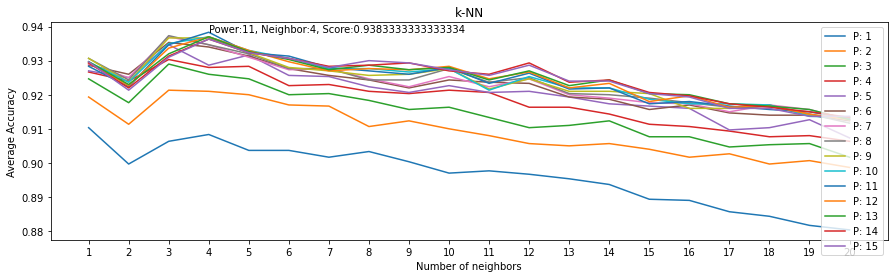

In [7]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
bp, bn, bs = 0, 0, 0
for p in n_powers:
    results = []
    distances = distance.pdist(X_train, 'minkowski', p)
    distances = distance.squareform(distances)
    for k in k_neighbors:
        print(f'Start validation: P:{p}, K:{k}')
        acc = leave_one_out(X_train, y_train, k, p, distances)
        if bs < acc: bp, bn, bs = p, k, acc
        results.append(acc)
        print(f"Finished, mean accuracy: {acc:.3%}")
    plt.plot(k_neighbors, results, label=f'P: {p}')
        
plt.text(bn, bs, f'Power:{bp}, Neighbor:{bn}, Score:{bs}')
plt.legend()
plt.show()

### b. Implement LOOCV to estimate the rick of the k-NN rule for k $\in\{1,...,20\}$

In [39]:
k_neighbors = np.linspace(1, 2, 2, dtype='int')

2/3000  | Valid Acc.: 50.00% 

start validate 1  neighbors


2/3000  | Valid Acc.: 50.00% 3% 

finished, mean accuracy: 0.9193333333333333
start validate 2  neighbors


3000/3000  | Valid Acc.: 91.13% 

finished, mean accuracy: 0.9113333333333333
451.13179445266724


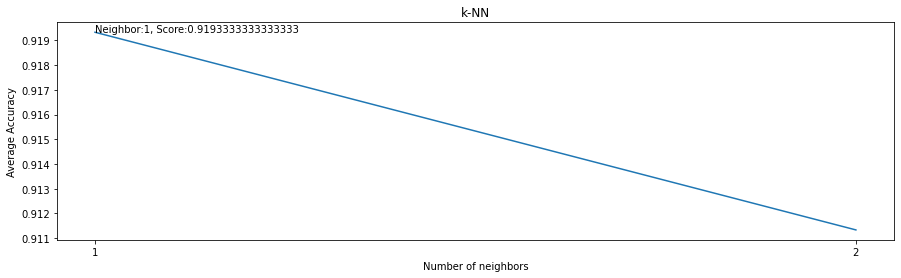

In [40]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
results = []
bn, bs = 0, 0
start_time = time.time()
for k in k_neighbors:
    # k-fold cv from scratch for k-NN
    print("start validate", k," neighbors")
    acc = mean(cross_val_score(X_train, y_train, cv=y_train.shape[0], k=k, p=2))
    results.append(acc)
    print("finished, mean accuracy:",acc)
    if (bs < acc): 
        bn, bs = k, acc

print(time.time() - start_time)
plt.text(bn, bs, f'Neighbor:{bn}, Score:{bs}')
plt.plot(k_neighbors, results)
plt.show()

In [37]:
k_neighbors = np.linspace(1, 2, 2, dtype='int')
print(k_neighbors)

[1 2]


split time: 58.54398226737976
Prediction Time: 0.1981492042541504
Prediction Time: 0.2520933151245117
Prediction Time: 0.23006010055541992
Prediction Time: 0.2412104606628418
Prediction Time: 0.21371746063232422
split time: 60.18520760536194
Prediction Time: 0.2518017292022705
Prediction Time: 0.25801753997802734
Prediction Time: 0.3056185245513916
Prediction Time: 0.2864997386932373


No handles with labels found to put in legend.


Prediction Time: 0.32613086700439453


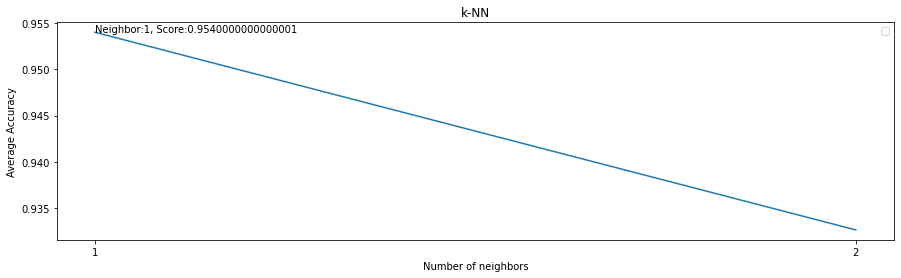

In [209]:
random.seed(1)
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
knn = []
bn, bs = 0, 0
for k in k_neighbors:
    # k-fold cv from scratch for k-NN
    acc = mean(cross_val_score(train_small, cv=5, k=k, p=2))
    knn.append(acc)
    if (bs < acc): 
        bn, bs = k, acc
plt.text(bn, bs, f'Neighbor:{bn}, Score:{bs}')
plt.plot(k_neighbors, knn)
plt.legend()
plt.show()

## d.Speed up k-NN $\in\{1,...,10\}$ (By data pre-processing)

In [158]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')
print(train_small)

[[6. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [9. 0. 0. ... 0. 0. 0.]
 ...
 [8. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [7. 0. 0. ... 0. 0. 0.]]


In [159]:
from scipy.stats import norm
import math
from sklearn import preprocessing
def get_nth_quartile(data, n):  
    if n<1 or n>3:
        return false
    data.sort()
    position = 1 + (len(data)-1)*n/4
    pos_integer = int(math.modf(position)[1])
    pos_decimal = position - pos_integer
    quartile = data[pos_integer - 1] + (data[pos_integer] - data[pos_integer - 1])*pos_decimal
    return quartile

def min_max_scaling(data):
    return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))

def standard_scaling(data):
    return preprocessing.normalize(data)

def max_abs_scaling(data):
    return np.where(abs(data.max(0)) == 0, data, data / abs(data.max(0)))

def robust_scaling(data):
    temp=data.copy()
    for i in range(len(data)):
        quartile=get_nth_quartile(data[i],1)
        quartiletre=get_nth_quartile(data[i],3)
        median=get_nth_quartile(data[i],2)
        if quartiletre-quartile != 0:
            temp[i]=[((temp[i][j] - median) / (quartiletre-quartile)) for j in range(len(temp[i]))]
    return temp

def unit_scaling(data):
    temp=np.ndarray(data.shape)
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] != 0:
                temp[i][j]=1
    return temp


In [160]:
y_train=train_small[:,0].copy()

In [161]:
X_train_mm = min_max_scaling(train_small[:,1:])
X_test_mm = min_max_scaling(test_small[:,1:])

<ipython-input-159-45e3d24a2e54>:15: RuntimeWarning: invalid value encountered in true_divide
  return np.where(data.ptp(0) == 0, data, (data - data.min(0)) / data.ptp(0))


In [162]:
X_train_ma = max_abs_scaling(train_small[:,1:])
X_test_ma = max_abs_scaling(test_small[:,1:])

<ipython-input-159-45e3d24a2e54>:21: RuntimeWarning: invalid value encountered in true_divide
  return np.where(abs(data.max(0)) == 0, data, data / abs(data.max(0)))


In [163]:
X_train_nr = standard_scaling(train_small[:,1:])
X_test_nr = standard_scaling(test_small[:,1:])

In [164]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')
X_train_rs = robust_scaling(train_small[:,1:])
X_test_rs = robust_scaling(test_small[:,1:])
# X_train_rs[3]

In [165]:
train_small = np.genfromtxt(
        'datasets/MNIST_train_small.csv', delimiter=',')
test_small = np.genfromtxt('datasets/MNIST_test_small.csv', delimiter=',')
# print(train_small)
X_train_unit = unit_scaling(train_small[:,1:])
X_test_unit = unit_scaling(test_small[:,1:])
# X_train_unit

In [166]:
k_neighbors = np.linspace(1, 10, 10, dtype='int')

start validate 1  neighbors


5/5  | Valid Acc.: 92.10% 

start validate 2  neighbors


5/5  | Valid Acc.: 91.50% 

start validate 3  neighbors


5/5  | Valid Acc.: 91.77% 

start validate 4  neighbors


5/5  | Valid Acc.: 92.10% 

start validate 5  neighbors


5/5  | Valid Acc.: 92.00% 

start validate 6  neighbors


5/5  | Valid Acc.: 91.83% 

start validate 7  neighbors


5/5  | Valid Acc.: 91.33% 

start validate 8  neighbors


5/5  | Valid Acc.: 91.43% 

start validate 9  neighbors


5/5  | Valid Acc.: 91.27% 

start validate 10  neighbors


5/5  | Valid Acc.: 91.20% 

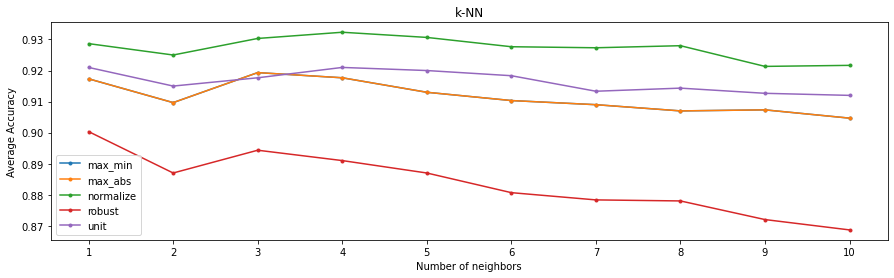

In [167]:
random.seed(1)
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xticks(k_neighbors)
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
knn1 = []
knn2 = []
knn3 = []
knn4 = []
knn5 = []
for k in k_neighbors:
    print("start validate", k," neighbors")
    # k-fold cv from scratch for k-NN
    acc1 = mean(cross_val_score(X_train_mm,y_train, cv=5, k=k, p=2))
    acc2 = mean(cross_val_score(X_train_ma,y_train, cv=5, k=k, p=2))
    acc3 = mean(cross_val_score(X_train_nr,y_train, cv=5, k=k, p=2))
    acc4 = mean(cross_val_score(X_train_rs,y_train, cv=5, k=k, p=2))
    acc5 = mean(cross_val_score(X_train_unit,y_train, cv=5, k=k, p=2))
    knn1.append(acc1)
    knn2.append(acc2)
    knn3.append(acc3)
    knn4.append(acc4)
    knn5.append(acc5)
plt.plot(k_neighbors, knn1, label="max_min",marker='.')
plt.plot(k_neighbors, knn2, label="max_abs",marker='.')
plt.plot(k_neighbors, knn3, label="normalize",marker='.')
plt.plot(k_neighbors, knn4, label="robust",marker='.')
plt.plot(k_neighbors, knn5, label="unit",marker='.')
plt.legend()
plt.show()

## PCA: Dimensionality Reduction

In [113]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_normed)
X_test_pca = pca.transform(X_test_normed)
# X_train_pca = pca.fit_transform(train_small[:,1:])
# X_test_pca = pca.transform(test_small[:,1:])

In [114]:
n_components = np.linspace(5,50,10, dtype='int')
k_neighbors = np.linspace(1,7,7, dtype='int')

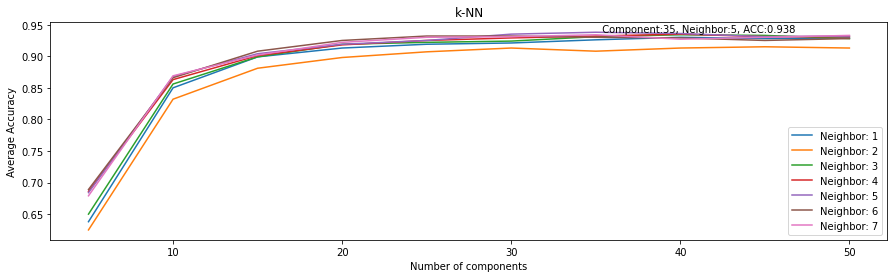

In [115]:
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xlabel("Number of components")
plt.ylabel("Average Accuracy")
bc, bn, bs = 0, 0, 0
for k in k_neighbors:
    knn = []
    for n_component in n_components:
        KNN = KNearestNeighbors(k, 2)
        KNN.fit(X_train_pca[:,:n_component], train_small[:,0])
        y_pred = KNN.predict(X_test_pca[:,:n_component])
        score = sum(y_pred==test_small[:,0])/test_small[:,0].shape[0]
        if score > bs:
            bc, bn, bs = n_component, k, score
        knn.append(score)
    plt.plot(n_components, knn, label=f'Neighbor: {k}')
plt.text(bc, bs,f"  Component:{bc}, Neighbor:{bn}, ACC:{bs}")
plt.legend()
plt.show()

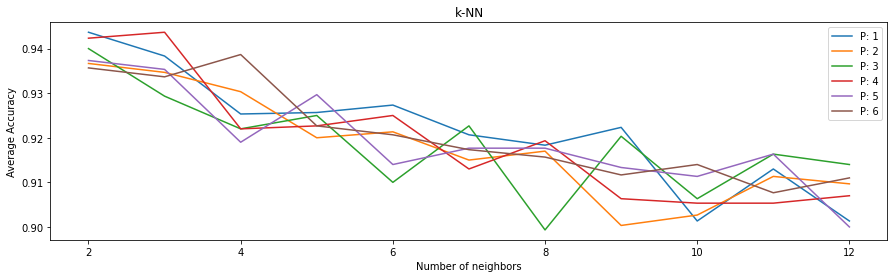

In [116]:
random.seed(1)
# plot the change in the average accuracy according to k
plt.figure(figsize = (15, 4))
plt.title("k-NN")
plt.xlabel("Number of neighbors")
plt.ylabel("Average Accuracy")
for p in range(1, 7):
    knn = []
    for k in range(2, 13):
        # k-fold cv from scratch for k-NN
        acc = mean(cross_val_score(train_small, cv=12, k=k, p=p))
        knn.append(acc)
    plt.plot(range(2, 13), knn, label=f'P: {p}')
plt.legend()
plt.show()
#         print(f'Accuracy: {acc:.3f}, K: {k}, P: {p}')
# plt.figure(figsize = (15, 4))
# plt.title("k-NN")
# plt.xlabel("Number of neighbors")
# plt.ylabel("Average Accuracy")
# plt.plot(range(2, 13), knn);